<a href="https://colab.research.google.com/github/mudesir/DS-Unit-2-Linear-Models/blob/master/LS_DS17_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [36]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [37]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [38]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [39]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [40]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [41]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [42]:
# We have developed a 10-dimensional system for rating 
# the burritos in San Diego. ... Generate models for what
# makes a burrito great and investigate correlations in its dimensions.
print('Shape ', df.shape)
df.head()

Shape  (421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Date            421 non-null    object 
 2   Yelp            87 non-null     float64
 3   Google          87 non-null     float64
 4   Chips           26 non-null     object 
 5   Cost            414 non-null    float64
 6   Hunger          418 non-null    float64
 7   Mass (g)        22 non-null     float64
 8   Density (g/mL)  22 non-null     float64
 9   Length          283 non-null    float64
 10  Circum          281 non-null    float64
 11  Volume          281 non-null    float64
 12  Tortilla        421 non-null    float64
 13  Temp            401 non-null    float64
 14  Meat            407 non-null    float64
 15  Fillings        418 non-null    float64
 16  Meat:filling    412 non-null    float64
 17  Uniformity      419 non-null    flo

In [44]:
# change the boolean value 'Great' true and false to int 1/0
df['Great'] = df['Great'].astype(int)

In [46]:
# cleaning data for high NaN values
data = df.filter(['Burrito', 'Date', 'Cost', 'Hunger', 'Tortilla', 'Temp', 
          'Meat', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Great'], 
          axis=1).copy()
data.head()        

,Burrito,Date,Cost,Hunger,Tortilla,Temp,Meat,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,California,1/18/2016,6.49,3.0,3.0,5.0,3.0,4.0,4.0,4.0,4.0,4.0,0
1,California,1/24/2016,5.45,3.5,2.0,3.5,2.5,2.0,4.0,3.5,2.5,5.0,0
2,Carnitas,1/24/2016,4.85,1.5,3.0,2.0,2.5,4.5,4.0,3.0,3.0,5.0,0
3,Asada,1/24/2016,5.25,2.0,3.0,2.0,3.5,4.0,5.0,4.0,4.0,5.0,0
4,California,1/27/2016,6.59,4.0,4.0,5.0,4.0,4.5,5.0,2.5,4.5,4.0,1


In [47]:
# formating the date
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)

In [48]:
data['Date'].shape

(421,)

Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & late

In [49]:
# change the boolean value 'Great' true and false to int 1/0
train.shape


(111, 13)

In [54]:
train = data[(data['Date']<'2016-12-31')]
print('Train ', train.shape)
validate = data[((data['Date']>='2017-01-01') & (data['Date']<='2017-12-31'))]
print('Validate', validate.shape)
test = data[((data['Date']>='2018-01-01'))]
print("Test ", test.shape)
print('Data ', data.shape)

Train  (298, 13)
Validate (85, 13)
Test  (38, 13)
Data  (421, 13)


In [55]:
# Begin with baselines for classification
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.590604
1    0.409396
Name: Great, dtype: float64

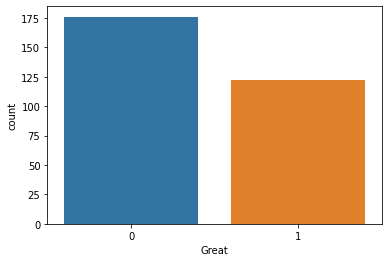

In [56]:
# visualiz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(y_train);

In [ ]:
# what is the baseline accuracy if we guessed the majority class for every prediction
majority_class =y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
y_pred


In [58]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5906040268456376

In [60]:
y_validate = validate[target]
y_pred = [majority_class] * len(y_validate)
accuracy_score(y_validate, y_pred)

0.5529411764705883

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 300
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Burrito       298 non-null    object        
 1   Date          298 non-null    datetime64[ns]
 2   Cost          292 non-null    float64       
 3   Hunger        297 non-null    float64       
 4   Tortilla      298 non-null    float64       
 5   Temp          283 non-null    float64       
 6   Meat          288 non-null    float64       
 7   Meat:filling  292 non-null    float64       
 8   Uniformity    296 non-null    float64       
 9   Salsa         278 non-null    float64       
 10  Synergy       296 non-null    float64       
 11  Wrap          296 non-null    float64       
 12  Great         298 non-null    int64         
dtypes: datetime64[ns](1), float64(10), int64(1), object(1)
memory usage: 42.6+ KB


Use scikit-learn for logistic regression.

In [63]:
# lets see linear regression
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
# Arrange X feature matrices
features = ['Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat:filling', 'Uniformity', 
            'Salsa', 'Synergy', 'Wrap']
X_train = train[features]
X_val = validate[features]
# impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.fit_transform(X_val)

# fit the model
linear_reg.fit(X_train_imputed, y_train)
# apply the model to new data
linear_reg.predict(X_val_imputed)


array([ 0.41965422,  0.45193524,  0.74855076,  0.64406933, -0.18099235,
        0.17614868,  0.85016902,  0.57960017, -0.15724305,  0.90417545,
        0.7992818 , -0.18872066,  0.13588988,  0.29336277,  1.10472023,
        0.44750081,  0.48575486,  0.59574337,  0.58796085,  1.14330507,
        0.57675008,  0.62503397,  0.1388471 ,  0.51029294,  0.62638428,
        0.57652513,  0.80516933,  0.38626492,  0.44721473,  0.60835589,
        0.84267358,  0.53020028,  0.28399198,  0.42110582,  0.45496778,
        0.49717914,  0.45243023,  0.6259508 ,  0.42261605,  0.66613015,
        0.40671907,  0.64484491,  0.62782563,  0.57746447,  0.65669084,
        0.55795615,  0.29588754,  0.39806758,  0.56275606, -0.09996229,
        0.19332528,  0.47280534,  0.8746622 ,  0.81136695,  0.47484081,
        0.19346203,  0.32110483,  0.25347064,  0.3134259 ,  0.30563364,
       -0.41772895,  0.35955308, -0.05652592,  0.48014629,  0.53745773,
        0.93015499,  0.56402432,  0.90936341,  0.69891468,  0.49

In [64]:
# get coefficients
pd.Series(linear_reg.coef_, features)

Cost            0.057519
Hunger          0.014227
Tortilla        0.076441
Temp            0.064248
Meat:filling    0.073284
Uniformity      0.014964
Salsa           0.046114
Synergy         0.229014
Wrap            0.007583
dtype: float64

In [66]:
test_case = [[7, 4, 3, 5, 3.5, 5, 4, 4.5, 5]]
linear_reg.predict(test_case)

array([0.7509955])

In [67]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy ', log_reg.score(X_val_imputed, y_validate))


Validation Accuracy  0.8117647058823529


In [68]:
# The prediction looklike
log_reg.predict(X_val_imputed)

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1])

In [70]:
# test case
test_case = [[7, 4, 3, 5, 3.5, 5, 4, 4.5, 5]]
log_reg.predict(test_case)

array([1])

In [71]:
log_reg.predict_proba(test_case)

array([[0.10287196, 0.89712804]])

In [75]:
# get coefficients

print(features, log_reg.coef_)

['Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap'] [[0.48254514 0.1673141  0.73836091 0.56026415 0.89352741 0.09825683
  0.30678529 2.32154084 0.11456239]]


In [76]:
log_reg.intercept_

array([-22.76327931])

In [77]:
# the logistic sigmoid 'squishing' function
import numpy as np
def sigmoid(X):
  return 1/(1+np.e**(-X))
  

In [78]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.89712804]])

In [79]:
# get validation
features = ['Burrito','Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat:filling', 
            'Uniformity', 'Salsa', 'Synergy', 'Wrap']
X_train = train[features]     
y_train = train[target]     
X_val = validate[features]  
y_val = validate[target]

import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [80]:
X_train

,Burrito,Cost,Hunger,Tortilla,Temp,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,California,6.49,3.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0
1,California,5.45,3.5,2.0,3.5,2.0,4.0,3.5,2.5,5.0
2,Carnitas,4.85,1.5,3.0,2.0,4.5,4.0,3.0,3.0,5.0
3,Asada,5.25,2.0,3.0,2.0,4.0,5.0,4.0,4.0,5.0
4,California,6.59,4.0,4.0,5.0,4.5,5.0,2.5,4.5,4.0
...,...,...,...,...,...,...,...,...,...,...
296,California,5.65,3.0,4.0,1.5,4.2,4.0,3.0,2.0,4.5
297,Other,5.49,3.0,4.5,5.0,2.5,3.5,3.0,2.5,3.0
298,California,7.75,4.0,3.5,2.5,1.4,2.3,2.2,3.3,4.5
299,Asada,7.75,4.0,4.0,4.5,3.5,3.5,2.0,2.0,4.0


In [83]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

X_train_encoded.head()


,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Cost,Hunger,Tortilla,Temp,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,1,0,0,0,0,6.49,3.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0
1,1,0,0,0,0,5.45,3.5,2.0,3.5,2.0,4.0,3.5,2.5,5.0
2,0,1,0,0,0,4.85,1.5,3.0,2.0,4.5,4.0,3.0,3.0,5.0
3,0,0,1,0,0,5.25,2.0,3.0,2.0,4.0,5.0,4.0,4.0,5.0
4,1,0,0,0,0,6.59,4.0,4.0,5.0,4.5,5.0,2.5,4.5,4.0


In [85]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)


In [87]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
y_pred = model.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.7647058823529411

In [89]:
# plot coefficients
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients

Burrito_California     0.198441
Burrito_Carnitas       0.216868
Burrito_Asada          0.009015
Burrito_Other         -0.164008
Burrito_Surf & Turf   -0.260590
Cost                   0.687659
Hunger                 0.091622
Tortilla               0.644113
Temp                   0.502393
Meat:filling           0.928254
Uniformity             0.205084
Salsa                  0.268586
Synergy                2.176767
Wrap                   0.070133
dtype: float64

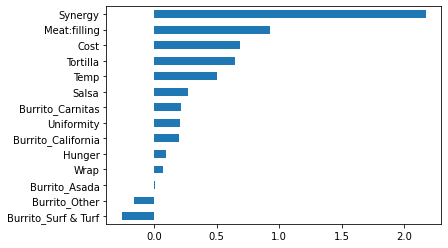

In [90]:
# plot
coefficients.sort_values().plot.barh();